# What to do:
 - Familiarize yourself with the concept of structural scaffolds. You probably already know it from the lecture materials, but just to be sure :)
 - Perform a scaffold analysis of the DrugBank database. Have a look at the most common scaffolds amongst drugs.
 - Perform a scaffold analysis of your ligand set. What are the most prevalent scaffolds/central structural motifs in your ligand set? 
 - Compare the scaffold composition of your ligand set and DrugBank. What are the differences? Are the scaffolds of your ligand set somewhat common amongst known drugs, or is it something more exotic?
 - Perform a scaffold-based diversity picking from your ligand set. Represent each scaffold in your ligand set by a single chemical structure.

# Co dělat:
  - Seznamte se s konceptem strukturní scaffold. Pravděpodobně už jej znáte z přednášek, ale jen pro jistotu :)
  - Proveďte scaffoldovou analýzu databáze DrugBank. Podívejte se na nejčastější scaffold mezi drugs.
  - Proveďte scaffold analýzu svojí sady ligandů. Jaké jsou nejčastější scaffoldy / centrální strukturální motivy ve vaší sadě ligandů?
  - Porovnejte složení scaffold sady ligandů a DrugBank. Jaké jsou rozdíly? Jsou scaffoldy vašeho ligandu mezi známými léky poněkud běžná, nebo je to něco exotičtějšího?
  - Proveďte výběr rozmanitosti na základě scaffoldů ze sady ligandů. Reprezentujte každý scaffold v sadě ligandů jedinou chemickou strukturou.

# Scaffoldová analýza

Chemickým substrukturám jsme se již rozsáhle zabývali ve [cvičení 5](05_substructures_and_filters.ipynb). Tam jsme pozorované substruktury definovali explicitně (MACCS a další strukturní klíče) nebo implicitně (ECFP, další fingerprinty). V tomto cvičení se pokusíme redukovat chemické struktury na jejich hlavní strukturní motiv, tj. Centrální charakteristický „rámec“ struktury.

Tyto „základní“ strukturní motivy, často nazývané „scaffoly“, se obvykle získají zbavením se všech specifik o atomech (atomový prvek, valence, náboj atd.) a vazeb (typ vazby, pořadí vazeb atd.), Odříznutím všechny postranních řetězců a mezi nimi jsou pouze kruhy a spojovací linkery. Některé scaffold metody dokonce kontraktují linkery, normalizují velikosti kruhů, postupně odstraňují kruhy atd. Úlohou scaffoldu je dívat se na chemické struktury abstraktnějším způsobem a seskupovat je na základě sdílených centrálních motivů.

Velmi oblíbeným typem scaffoldu je to, čemu říkáme „Murcko scaffold“, které se získá normalizací všech atomů a vazeb zpracované struktury a následným odstraněním postranního řetězce. Některé scaffold metody jsou [implementovány v RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.html), včetně Murcko scaffold, která v tomto cvičení použijeme.

Spoustu užitečných informací o scaffoldech naleznete v [článku OG](https://sci-hub.tw/https://pubs.acs.org/doi/10.1021/jm9602928)

In [226]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import math
import csv
import pandas as pd

**Načtení množiny ligandů pro COX1**

Tentokrát načteme [hodnotu pChEMBL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965067/) vedle našich ligandů. Jedná se o standardizovanou hodnotu aktivity přiřazenou ChEMBL na základě skutečných naměřených hodnot (EC50, IC50, Ki atd.). Jeho použití je jednodušší než prvotní měření, i když postrádá přímou interpretaci a je v zásadě „čím více pChEMBL, tím více adidas “. Je to však velmi užitečné pro hrubé uspořádání a srovnání, tj. Co zde budeme dělat. Pokud dáváte přednost jiným měřením, načtěte jakýkoli požadovaný typ aktivity.

In [227]:
raw_df = pd.read_csv('data/cyclooxygenase_1.csv', sep=';') 
raw_df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL270043,NaN,0,306.34,0,1.80,22,COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1O,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1141614,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
1,CHEMBL270264,NaN,0,306.34,0,1.80,19,COc1cc(/C=N/c2ccc(S(N)(=O)=O)cc2)ccc1O,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1141614,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
2,CHEMBL260386,NaN,0,281.24,0,2.93,22,Nc1ccc(C(=O)Nc2ccc(C(F)(F)F)cc2)nc1,IC50,'>',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1144769,1,Scientific Literature,J. Med. Chem.,2008.0,None,NaN
3,CHEMBL259972,MOFEZOLAC,0,339.35,0,3.65,"4, mofezolac",COc1ccc(-c2noc(CC(=O)O)c2-c2ccc(OC)cc2)cc1,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1144769,1,Scientific Literature,J. Med. Chem.,2008.0,None,NaN
4,CHEMBL122,ROFECOXIB,4,314.36,0,2.56,Rofecoxib,CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1,IC50,'=',...,Cyclooxygenase-1,Homo sapiens,SINGLE PROTEIN,CHEMBL1145760,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2003.0,None,NaN


In [228]:
# odstraneni dat, ktere nemaji IC50 nebo maji jinou jednotku nez nM,
# tim se odstrani data, ktere nemaji Smiles
df = raw_df[(raw_df['Standard Units'] == 'nM')]

cox_ligands = []
for index,row in df.iterrows(): 
    mol = Chem.MolFromSmiles(row['Smiles'])
    # get the standardized pChEMBL activity measure for future use
    pchembl = row['pChEMBL Value']
    if (math.isnan(pchembl) or not pchembl):
        # some don't have any comparable pChEMBL value, just assign them very low value
        pchembl = -1
    mol.SetDoubleProp('pChEMBL', float(pchembl)) # save the value into mol instance
    cox_ligands.append(mol)
    
cox_ligands[:10]

**Načtení množiny DrugBank**

In [229]:
suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

 - Proveďte scaffoldovou analýzu databáze DrugBank. Podívejte se na nejčastější scaffold mezi drugs.

Pojďme se podívat na první ligand v naší sadě:

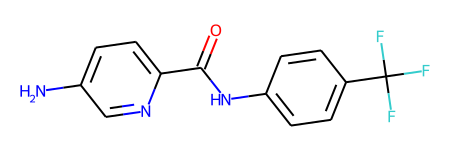

In [230]:
cox_ligands[2]

Jeho scaffold:

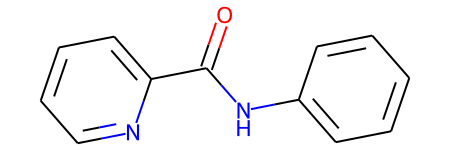

In [231]:
from rdkit.Chem.Scaffolds import MurckoScaffold

scaffold1 = MurckoScaffold.GetScaffoldForMol(cox_ligands[2])
scaffold1

Byly odstraněny postranní řetězce, ale všechny heteroatomy stále zůstávají. Normalizace všech atomů na uhlík, všechny vazby na jednoduché:

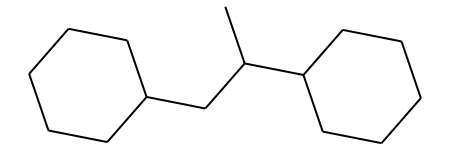

In [232]:
scaffold2 = MurckoScaffold.MakeScaffoldGeneric(scaffold1)
scaffold2

Dostali jsme mnohem hrubší obrys. 

Zbavení se bočních řetězců opětovným spuštěním přes scaffold RDKit:

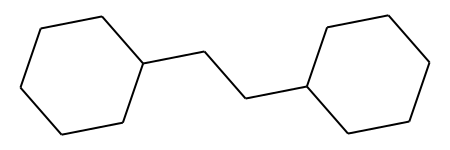

In [233]:
scaffold3 = MurckoScaffold.GetScaffoldForMol(scaffold2)
scaffold3

... což nám dává obnaženou kostru/ základní kostru našeho druhého ligandu. Všechny heteroatomy, vazby, postranní řetězce jsou odstraněny. Vypadá to jako docela holé jádro struktury Markush. 

Pro větší pohodlí implementace procesu scaffold jako funkci:

In [234]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

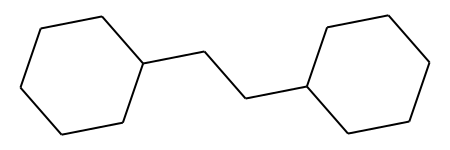

In [235]:
# vyzkouseni funkce scaffold
scaffold(cox_ligands[2])

Zdá se, že funkce funguje dobře. 

Dále scaffoldy všech drugs v DrugBank:

In [236]:
drugbank_scaffolds = [scaffold(drug) for drug in drugs if scaffold(drug) is not None]
drugbank_scaffolds[:10]

Generované scaffoldy jsou všechny instance RDKit Mol. Pro snadné srovnání je změním na řetězce SMILES. 
Identické lešení = identické lešení SMILES = identické textové řetězce. Přímé porovnání instancí by bylo mnohem méně výhodné.

In [237]:
drugbank_scaffolds_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugbank_scaffolds) if mol]
drugbank_scaffolds_smiles[:20]

[(0,
  'C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1'),
 (1,
  'C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1'),
 (2, 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1'),
 (3,
  'C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1'),
 (4, 'C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1'),
 (5, 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1'),
 (6, 'C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1'),
 (7, 'C1CCCCC1'),
 (8, 'C1CCC(CCC2CCC3CCCCC3C2)CC1'),
 (9, 'C1CCCC1'),
 (10, 'C1CCC2C(C1)CCC2C1CCCC1'),
 (11, ''),
 (12, 'C1CCCCC1'),
 (13, 'C1CC2CCCC2C1'),
 (14, ''),
 (15, ''),
 (16, ''),
 (17, 'C1CCCC1'),
 (18, ''),
 (19, '')]

Některé struktury nemají scaffold (nebo, jinými slovy, nemají scaffold s nulovými atomy). Pár struktur, které nemají scaffold:

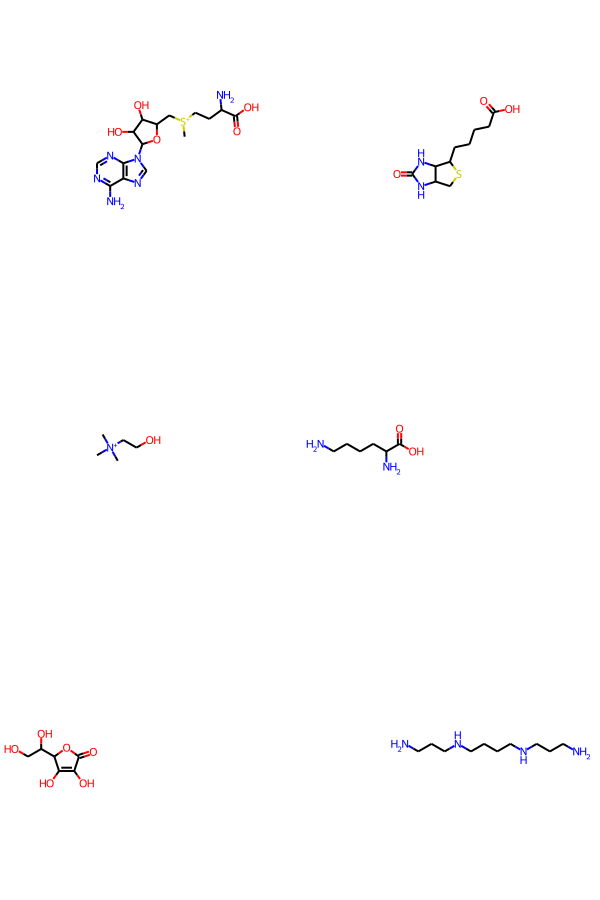

In [238]:
# to jsou latky bez scaffoldu
without_scaffold = [drugs[d[0]] for d in drugbank_scaffolds_smiles[:20] if d[1]=='']
Draw.MolsToGridImage(without_scaffold, molsPerRow=2, subImgSize=(300,300))

Funkce scaffold odstraní všechny postranní řetězce a ponechává pouze kruhy a jejich linkery. Žádný kruh znamená prázdný scaffold pro tuto implementaci scaffoldu.

Struktura s indexem 8 nebyla vůbec vylezena. Pojďme se na to podívat:

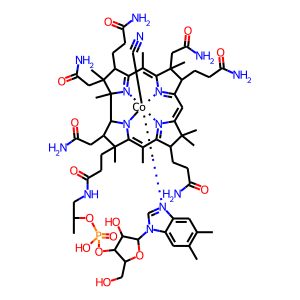

In [239]:
display(Chem.Draw.MolToImage(drugs[8]))

... jo, uhlíky to tady nezvládnou, šestimocný kobalt pokazí scaffold. Pokračujme s drtivou většinou struktur, které lze transformovat do jejich obecného strukturního motivu založeného na C, a seskupme je podle jejich scaffoldu:

In [240]:
scaffolds2drugs = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles}
for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles:
    scaffolds2drugs[scaffoldsmiles].append(drug_idx)
# jen pro vypsani 6 prvnich klicu a hodnot ve scaffolds2drugs
{A:N for (A,N) in [x for x in scaffolds2drugs.items()][:6]}

{'C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1': [0,
  2055],
 'C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1': [1,
  526],
 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1': [2, 5, 2320],
 'C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1': [3,
  4661],
 'C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1': [4],
 'C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1': [6]}

Výše je dictionary se scaffoldy ve SMILES, mapující na ID léků, které je obsahují. Můžeme spočítat ID přiřazená každému lešení, abychom získali představu, které scaffoldy jsou mezi drugs nejčastější:

In [241]:
scaffold_drugcount = [(scaffold, len(drugs)) for scaffold, drugs in scaffolds2drugs.items()]
len(scaffold_drugcount), scaffold_drugcount[:15]

(1545,
 [('C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1',
   2),
  ('C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1',
   2),
  ('C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1', 3),
  ('C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1',
   2),
  ('C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1', 1),
  ('C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1', 1),
  ('C1CCCCC1', 1039),
  ('C1CCC(CCC2CCC3CCCCC3C2)CC1', 54),
  ('C1CCCC1', 188),
  ('C1CCC2C(C1)CCC2C1CCCC1', 165),
  ('', 976),
  ('C1CC2CCCC2C1', 15),
  ('C1CCC(CCC2CCCC3CCCC32)CC1', 28),
  ('C(CCCCCCCCCC1CCCCC1)CCCCCCCCC1CCCCC1', 2),
  ('C1CCC2CC3CCCCC3CC2C1', 57)])

In [242]:
# serazeni od nejpocetnejsiho scaffolu k mene pocetnim
scaffold_drugcount.sort(key=lambda x: x[1], reverse=True)
scaffold_drugcount[:15]

[('C1CCCCC1', 1039),
 ('', 976),
 ('C1CCC2CCCC2C1', 192),
 ('C1CCCC1', 188),
 ('C1CCC(CC2CCCCC2)CC1', 182),
 ('C1CCC(C2CCCC2)CC1', 176),
 ('C1CCC2CCCCC2C1', 170),
 ('C1CCC2C(C1)CCC2C1CCCC1', 165),
 ('C1CCC2C(C1)CCC1C3CCCC3CCC21', 151),
 ('C1CCC(CCC2CCCCC2)CC1', 106),
 ('C1CCC(C2CCCCC2)CC1', 105),
 ('C1CCC(CC2CCCC2)CC1', 74),
 ('C1CCC(CCCC2CCCCC2)CC1', 66),
 ('C1CCC2CC3CCCCC3CC2C1', 57),
 ('C1CCC(CCC2CCC3CCCCC3C2)CC1', 54)]

In [243]:
draw_molecules = [Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[:20]]
draw_molecules

1039


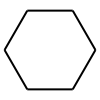




976


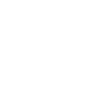




192


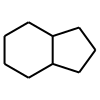




188


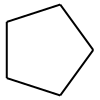




182


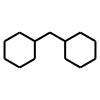




176


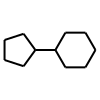




170


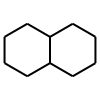




165


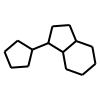




151


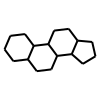




106


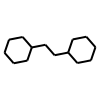




105


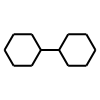




74


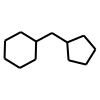




66


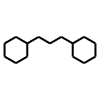




57


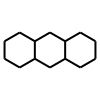




54


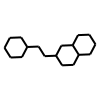




53


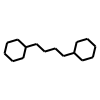




48


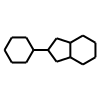




43


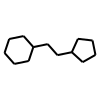




41


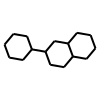




34


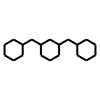

In [244]:
# nefunguje, nic nevykresluje
# Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[:20]],
#                      molsPerRow=2, subImgSize=(300,300),
#                      legends=[str(count) for scaffold, count in scaffold_drugcount[:20]])
legends=[str(count) for scaffold, count in scaffold_drugcount[:20]]

for i in range(len(draw_molecules)):
    print(legends[i])
    display(Draw.MolToImage(draw_molecules[i],size=(100,100)))
    print('\n\n')

Nahoře máme v DrugBank nejběžnější Murcko scaffold. Zdá se, že mnoho látek v DrubBank je jen nějaký šestičlenný kruh s postranními řetězci a téměř tolik z nich je zcela acyklických. To znamená, že mnoho molekul DrugBank je poměrně jednoduchých a malých. V návaznosti na tyto dva motivy máme struktury založené na pětičlenných kruzích a spoustu docela standardně vypadajících uspořádání dvou kruhů. Nejčastějším motivem se třemi kruhy je Ademetionine a [podobné struktury](https://www.drugbank.ca/structures/search/small_molecule_drugs/structure?database_id=DB00118&search_type=similarity#results) s širokou paletou použití. Hned vedle je již velmi velký motiv se 4 kruhy a jsem si jist, že steroidní jádro poznáte i na této úrovni zjednodušení;). Jiná častá scaffoldů se zdá víceméně stejná, samozřejmě, uspořádání se dvěma nebo třemi kruhy.


Jen vyzkoušet, jak by vypadala množina scaffoldů pro méně obecné scaffoldy:

In [245]:
def scaffoldLessGeneral(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
#         scaff = MurckoScaffold.GetScaffoldForMol(mol)
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
#     scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

RDKit ERROR: [13:12:39] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bad size
RDKit ERROR: Violation occurred on line 707 in file /opt/conda/conda-bld/rdkit_1603173682698/work/Code/GraphMol/MolDraw2D/MolDraw2D.cpp
RDKit ERROR: Failed Expression: !legends || legends->size() == mols.size()
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [13:55:53] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bad size
RDKit ERROR: Violation occurred on line 707 in file /opt/conda/conda-bld/rdkit_1603173682698/work/Code/GraphMol/MolDraw2D/MolDraw2D.cpp
RDKit ERROR: Failed Expression: !legends || legends->size() == mols.size()
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [13:56:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bad size
RDKit ERROR: Violation occurred on line 707 in file /opt/conda/conda-bld/rdkit_1603173682698/work/Code/GraphMol/MolDraw2D/MolDraw2D.cpp
RDKit ERROR: Failed Expression

26


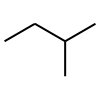




22


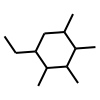




20


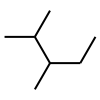




19


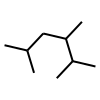




18


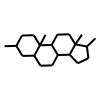




18


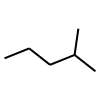




17


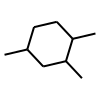




16


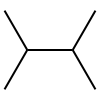




15


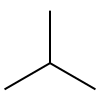




14


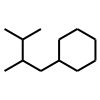




14


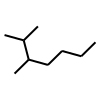




13


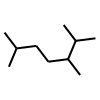




13


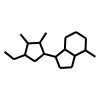




12


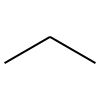




11


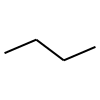




11


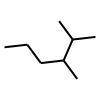




11


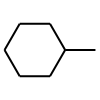




10


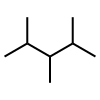




10


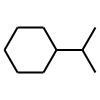




10


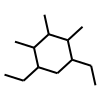

In [246]:
drugbank_scaffolds_lg = [scaffoldLessGeneral(drug) for drug in drugs if scaffold(drug) is not None]
drugbank_scaffolds_smiles_lg = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugbank_scaffolds_lg) if mol]

scaffolds2drugs_lg = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles_lg}
for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles_lg:
    scaffolds2drugs_lg[scaffoldsmiles].append(drug_idx)
    
scaffold_drugcount_lg = [(scaffold, len(drugs)) for scaffold, drugs in scaffolds2drugs_lg.items()]
scaffold_drugcount_lg.sort(key=lambda x: x[1], reverse=True)

# nefunguje, nic nevykresluje
# Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[:20]],
#                      molsPerRow=2, subImgSize=(300,300),
#                      legends=[str(count) for scaffold, count in scaffold_drugcount[:20]])
draw_molecules_lg = [Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount_lg[:20]]
legends_lg=[str(count) for scaffold, count in scaffold_drugcount_lg[:20]]

for i in range(len(draw_molecules_lg)):
    print(legends_lg[i])
    display(Draw.MolToImage(draw_molecules_lg[i],size=(100,100)))
    print('\n\n')

Jen vyzkoušet, jak by vypadala množina scaffoldů pro nechani heteroatomu scaffoldy:

In [247]:
def scaffoldHeteroatoms(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
#         scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
        scaff = MurckoScaffold.GetScaffoldForMol(mol)
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
#     scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

RDKit ERROR: [15:33:22] Explicit valence for atom # 90 C, 6, is greater than permitted
RDKit ERROR: [15:33:22] Explicit valence for atom # 62 C, 6, is greater than permitted
RDKit ERROR: [15:33:22] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [15:33:25] Explicit valence for atom # 31 C, 6, is greater than permitted
RDKit ERROR: [15:33:25] Explicit valence for atom # 14 C, 10, is greater than permitted
RDKit ERROR: [15:33:27] Explicit valence for atom # 23 C greater than permitted
RDKit ERROR: [15:33:27] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:33:27] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [15:33:28] Explicit valence for atom # 40 C, 6, is greater than permitted
RDKit ERROR: [15:33:28] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:33:28] Explicit valence for atom # 31 C, 6, is greater than permitted
RDKit ERROR: [15:33:28] Explicit valence for atom # 2

976


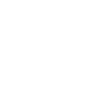




637


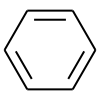




131


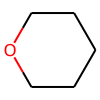




100


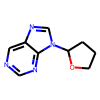




49


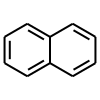




47


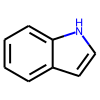




46


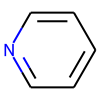




46


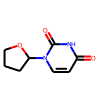




46


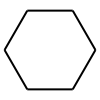




44


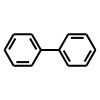




30


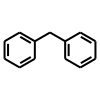




29


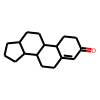




26


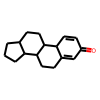




24


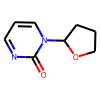




23


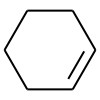




22


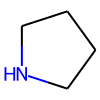




22


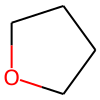




21


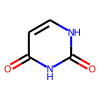




20


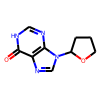




19


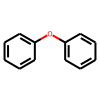

In [248]:
drugbank_scaffolds_h = [scaffoldHeteroatoms(drug) for drug in drugs if scaffold(drug) is not None]
drugbank_scaffolds_smiles_h = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugbank_scaffolds_h) if mol]

scaffolds2drugs_h = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles_h}
for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles_h:
    scaffolds2drugs_h[scaffoldsmiles].append(drug_idx)
    
scaffold_drugcount_h = [(scaffold, len(drugs)) for scaffold, drugs in scaffolds2drugs_h.items()]
scaffold_drugcount_h.sort(key=lambda x: x[1], reverse=True)

# nefunguje, nic nevykresluje
# Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[:20]],
#                      molsPerRow=2, subImgSize=(300,300),
#                      legends=[str(count) for scaffold, count in scaffold_drugcount[:20]])
draw_molecules_h = [Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount_h[:20]]
legends_h=[str(count) for scaffold, count in scaffold_drugcount_h[:20]]

for i in range(len(draw_molecules_h)):
    print(legends_h[i])
    display(Draw.MolToImage(draw_molecules_h[i],size=(100,100)))
    print('\n\n')

Stejná scaffoldová analýza pro moji sadu ligandů COX1 a podívat se, jestli / jak se liší od obvyklých věcí DrugBank

- Proveďte scaffold analýzu svojí sady ligandů. Jaké jsou nejčastější scaffoldy / centrální strukturální motivy ve vaší sadě ligandů?

In [249]:
# cox_scaffolds_smiles=[]

# for i, ligand in enumerate(cox_ligands):
#     scaff = scaffold(ligand)
#     print(scaff)
# #     print(Chem.MolToSmiles(scaff))
#     if(scaff is not None):
#         print('None nefunguje podminka')
#         cox_scaffolds_smiles.append((i, Chem.MolToSmiles(scaffold(ligand))))
# cox_scaffolds_smiles[:20]


cox_scaffolds_smiles = [(i, Chem.MolToSmiles(scaffold(ligand))) for i, ligand in enumerate(cox_ligands) if scaffold(ligand) is not None]
cox_scaffolds_smiles[:20]

RDKit ERROR: [15:33:54] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [15:33:54] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [15:33:55] Explicit valence for atom # 13 C, 6, is greater than permitted
RDKit ERROR: [15:33:55] Explicit valence for atom # 14 C, 6, is greater than permitted
RDKit ERROR: [15:33:55] Explicit valence for atom # 5 C, 6, is greater than permitted
RDKit ERROR: [15:33:55] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:33:55] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:33:56] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [15:33:58] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [15:33:58] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:33:58] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:33:58] Explicit valence for atom #

[(0, 'C1CCC(CCC2CCCCC2)CC1'),
 (1, 'C1CCC(CCC2CCCCC2)CC1'),
 (2, 'C1CCC(CCC2CCCCC2)CC1'),
 (3, 'C1CCC(C2CCCC2C2CCCCC2)CC1'),
 (4, 'C1CCC(C2CCCC2C2CCCCC2)CC1'),
 (5, 'C1CCC(C2CC3CCCCC3C2C2CCCCC2)CC1'),
 (6, 'C1CCC2CCCCC2C1'),
 (7, 'C1CCC(C2CCCC2C2CCCCC2)CC1'),
 (8, 'C1CCC2C(C1)CC1C2CCCC12CCC1CCCCC12'),
 (9, 'C1CCCCC1'),
 (10, 'C1CCC(CCC2CCCCC2)CC1'),
 (11, 'C1CCC(CC2CCCCC2)CC1'),
 (12, 'C1CCC(C2CCCCC2C2CCCCC2)CC1'),
 (13, 'C1CCC(CCC2CCCCC2)CC1'),
 (14, 'C1CCC(CCC2CCCCC2)CC1'),
 (15, 'C1CCC(C2CCCC(CC3CCCC3)C2)CC1'),
 (16, 'C1CCC(CCC2CCCCC2)CC1'),
 (17, 'C1CCC(CCC2CCCCC2)CC1'),
 (18, 'C1CCC(C2CCCCC2)CC1'),
 (19, 'C1CCC(CCCCC2CC(CC3CCCCC3)C3CCCCC23)CC1')]

In [250]:
cox_scaffolds2ligands = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles}
for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles:
    cox_scaffolds2ligands[scaffoldsmiles].append(ligand_idx)
{A:N for (A,N) in [x for x in cox_scaffolds2ligands.items()][:2]}

{'C1CCC(CCC2CCCCC2)CC1': [0,
  1,
  2,
  10,
  13,
  14,
  16,
  17,
  28,
  31,
  35,
  90,
  119,
  120,
  121,
  123,
  172,
  177,
  178,
  223,
  252,
  253,
  254,
  257,
  287,
  342,
  354,
  378,
  379,
  494,
  501,
  530,
  536,
  549,
  555,
  583,
  598,
  599,
  600,
  771,
  851,
  888,
  952,
  953,
  954,
  1026,
  1077,
  1084,
  1089,
  1151,
  1155,
  1157,
  1160,
  1192,
  1210,
  1250,
  1252,
  1274,
  1290,
  1297,
  1330,
  1331,
  1339,
  1341,
  1342,
  1349,
  1358,
  1359,
  1360,
  1361,
  1381,
  1479,
  1484,
  1524,
  1538,
  1539,
  1540,
  1543,
  1547,
  1578,
  1584,
  1655,
  1851,
  1868,
  1987,
  1988,
  2057,
  2058,
  2064,
  2083,
  2094,
  2095,
  2098,
  2101,
  2108,
  2135,
  2180,
  2182,
  2195,
  2196,
  2199,
  2214,
  2216,
  2217,
  2233,
  2246,
  2254,
  2274,
  2275,
  2278,
  2279,
  2291,
  2329,
  2421,
  2422,
  2490,
  2495,
  2535,
  2539,
  2540,
  2541,
  2614,
  2633,
  2637,
  2646,
  2647,
  2649,
  2654,
  2656,
  26

In [251]:
cox_scaffold_ligandcount = [(scaffold, len(ligands)) for scaffold, ligands in cox_scaffolds2ligands.items()]
cox_scaffold_ligandcount.sort(key=lambda x: x[1], reverse=True)
len(cox_scaffold_ligandcount), cox_scaffold_ligandcount

(281,
 [('C1CCC(C2CCCC2C2CCCCC2)CC1', 897),
  ('C1CCC(CC2CCCCC2)CC1', 163),
  ('C1CCC(CCC2CCCCC2)CC1', 146),
  ('C1CCC(CC2CCC3CCCCC32)CC1', 130),
  ('C1CCC2CCCCC2C1', 118),
  ('C1CCC(C2CCCCC2C2CCCCC2)CC1', 101),
  ('C1CCC(CC2CCCC2)CC1', 68),
  ('C1CCC(C2CCCC2)CC1', 61),
  ('C1CCC(C2CCCC2C2CCCC2)CC1', 53),
  ('C1CCCCC1', 48),
  ('C1CCC(C2CC(C3CCCCC3)C(C3CCCCC3)C2)CC1', 47),
  ('C1CCC(CC2CCCC2C2CCCCC2)CC1', 42),
  ('C1CCC(C2CC3CCCC3C2C2CCCCC2)CC1', 38),
  ('C1CCC(C2CC3CCCCC3C2C2CCCCC2)CC1', 37),
  ('C1CCC(CC2CCCCC2C2CCCCC2)CC1', 37),
  ('C1CCC(CCCC2CCCCC2)CC1', 34),
  ('C1CCC(C2CCC3CCC4CCCCC4C32)CC1', 33),
  ('C1CCC(C2CC3(CC3)CC2C2CCCCC2)CC1', 33),
  ('C(CCC1CCC2CCC(C3CCCCC3)CC2C1)CCC1CC(C2CCCCC2)C(C2CCCCC2)C1', 30),
  ('C1CCC(C2CCCCC2)CC1', 28),
  ('C1CCC2CCCC2C1', 28),
  ('C1CCC(CC2CCC3CCCC3C2)C1', 28),
  ('C1CCC(CC2CCC3CCCC3C2)CC1', 27),
  ('C1CCC(C2CC3C4CCCCC4CCC3C2C2CCCCC2)CC1', 27),
  ('C1CCC(C2CCC3CCCCC3C2)CC1', 26),
  ('C1CCC(CC2CCC(CCCC3CCCC3)CC2)CC1', 26),
  ('C1CCC(C2CC(C3CCCC

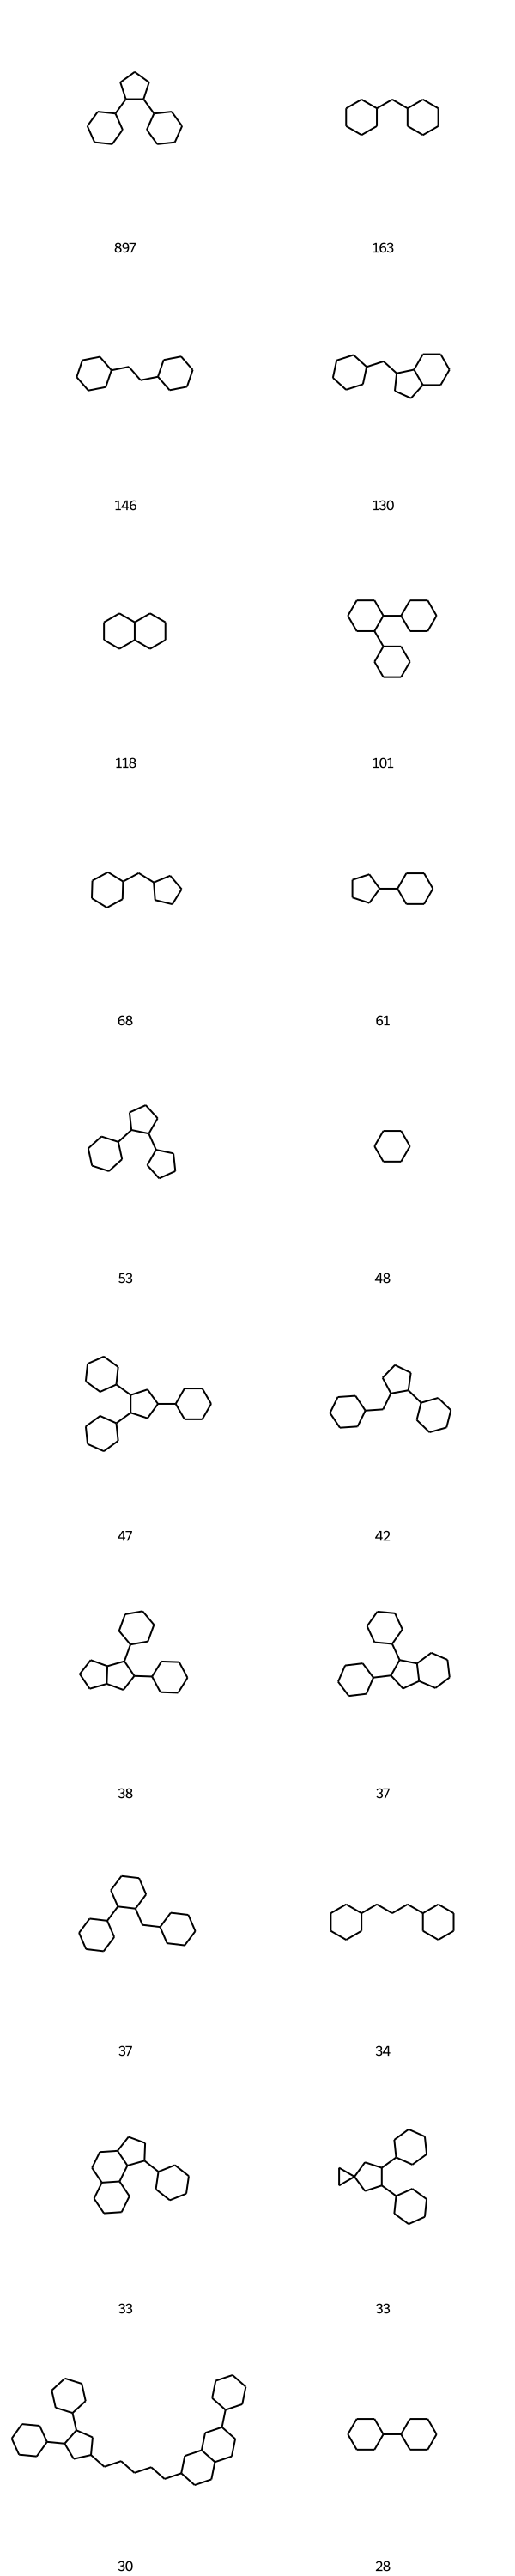

In [252]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in cox_scaffold_ligandcount[:20]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in cox_scaffold_ligandcount[:20]])

Běžné scaffolds mezi analyzovanými cox ligandy se zdají celkem podobné těm, které jsou v DrugBank. 

Ještě se mrknu na ne tak ořezané scaffoldy:

RDKit ERROR: [15:34:03] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [15:34:03] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [15:34:04] Explicit valence for atom # 13 C, 6, is greater than permitted
RDKit ERROR: [15:34:04] Explicit valence for atom # 14 C, 6, is greater than permitted
RDKit ERROR: [15:34:04] Explicit valence for atom # 5 C, 6, is greater than permitted
RDKit ERROR: [15:34:04] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:34:04] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:34:05] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [15:34:06] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [15:34:06] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:34:06] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [15:34:07] Explicit valence for atom #

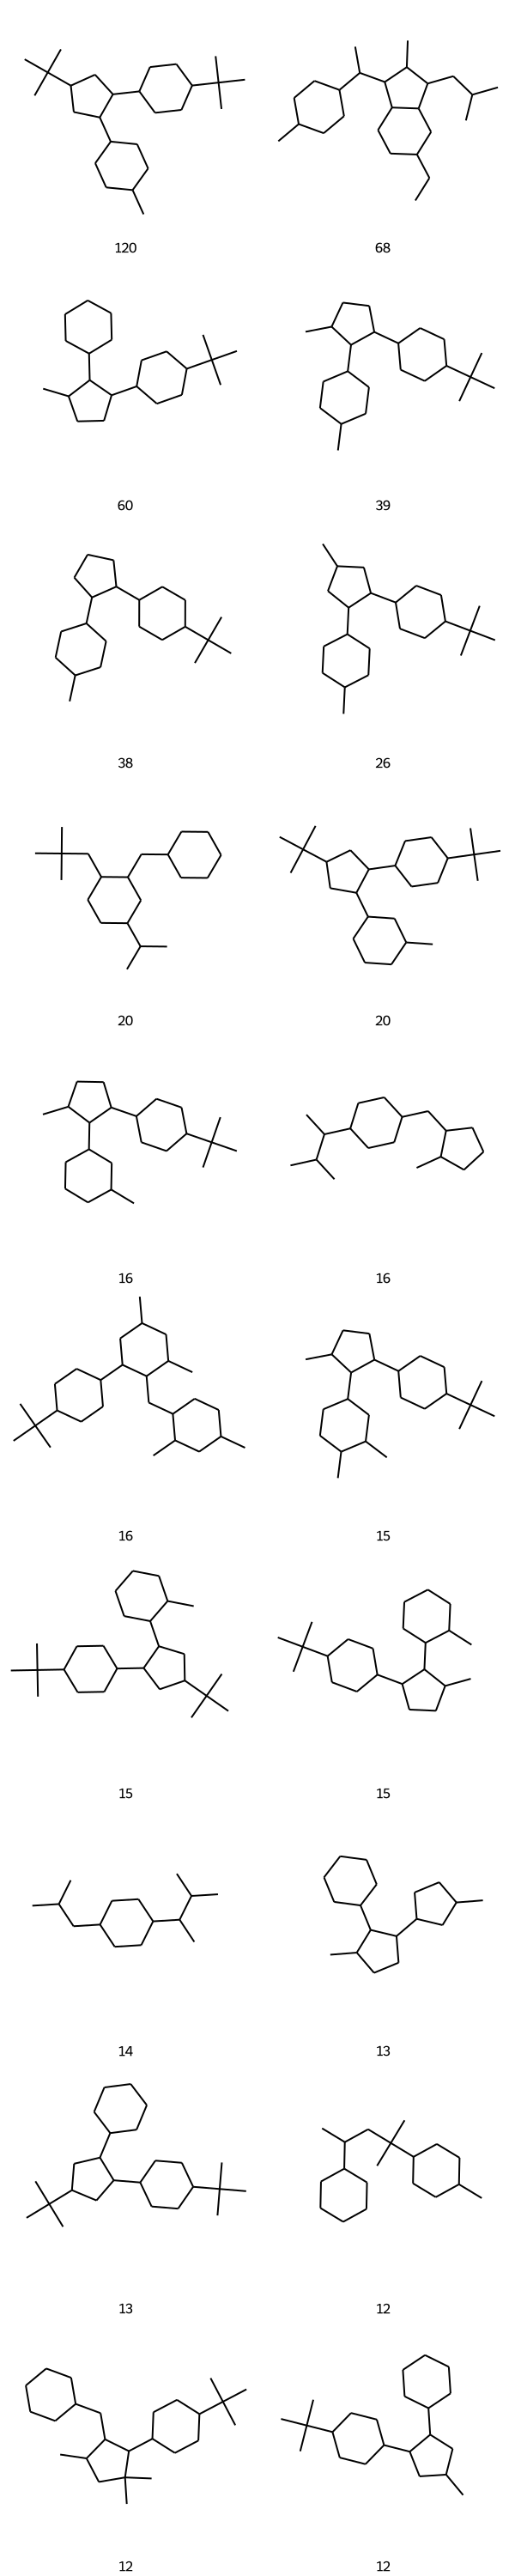

In [253]:
cox_scaffolds_smiles_lg = [(i, Chem.MolToSmiles(scaffoldLessGeneral(ligand))) for i, ligand in enumerate(cox_ligands) if scaffoldLessGeneral(ligand) is not None]

cox_scaffolds2ligands_lg = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles_lg}
for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles_lg:
    cox_scaffolds2ligands_lg[scaffoldsmiles].append(ligand_idx)

cox_scaffold_ligandcount_lg = [(scaffold, len(ligands)) for scaffold, ligands in cox_scaffolds2ligands_lg.items()]
cox_scaffold_ligandcount_lg.sort(key=lambda x: x[1], reverse=True)

Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in cox_scaffold_ligandcount_lg[:20]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in cox_scaffold_ligandcount_lg[:20]])

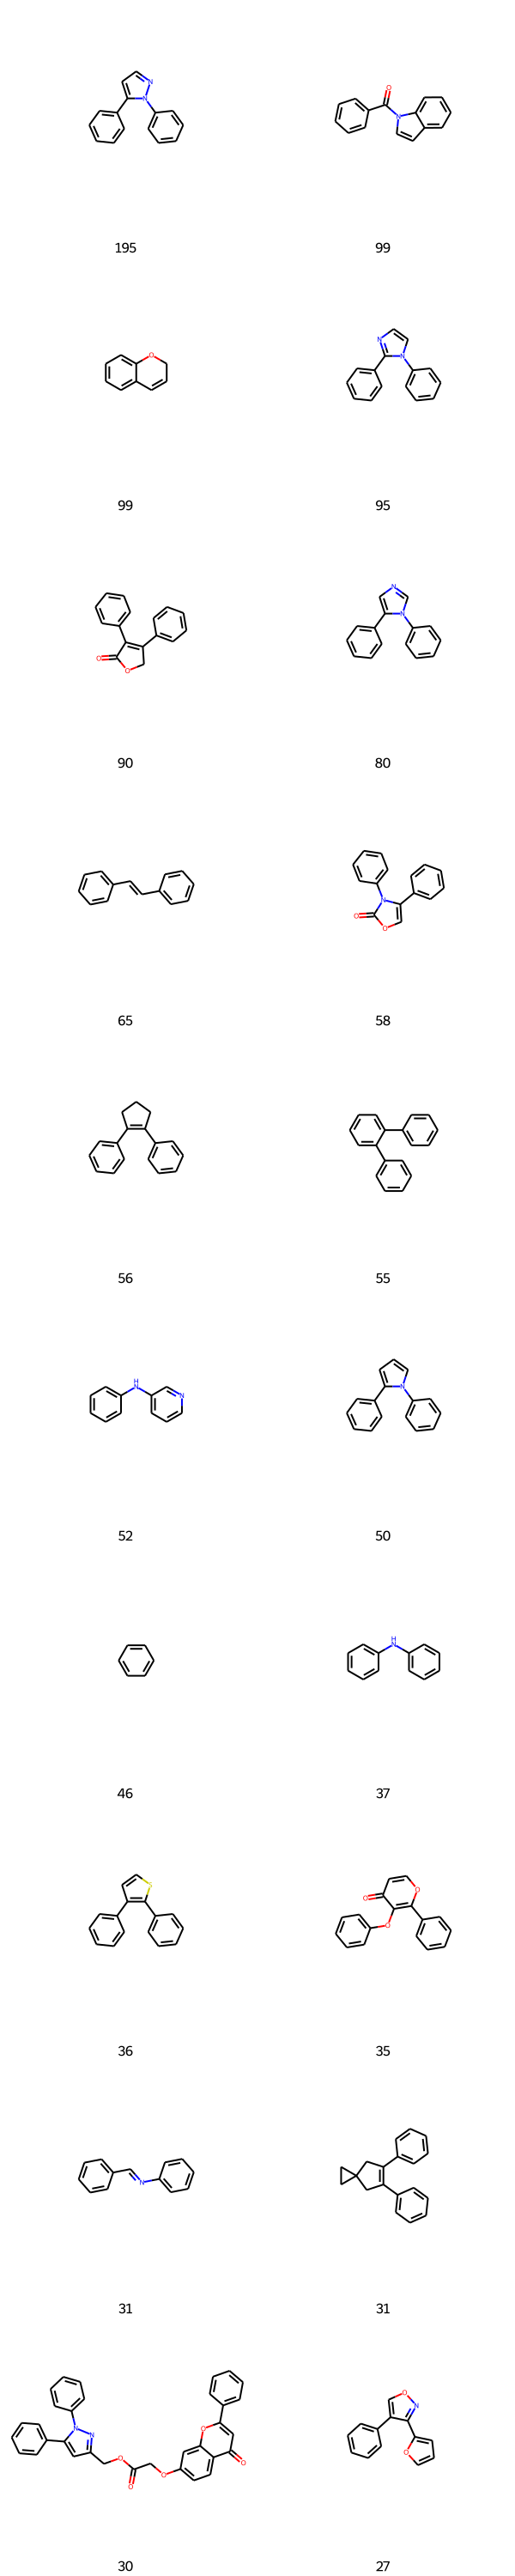

In [254]:
cox_scaffolds_smiles_h = [(i, Chem.MolToSmiles(scaffoldHeteroatoms(ligand))) for i, ligand in enumerate(cox_ligands) if scaffoldHeteroatoms(ligand) is not None]

cox_scaffolds2ligands_h = {scaffoldsmiles:[] for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles_h}
for ligand_idx, scaffoldsmiles in cox_scaffolds_smiles_h:
    cox_scaffolds2ligands_h[scaffoldsmiles].append(ligand_idx)

cox_scaffold_ligandcount_h = [(scaffold, len(ligands)) for scaffold, ligands in cox_scaffolds2ligands_h.items()]
cox_scaffold_ligandcount_h.sort(key=lambda x: x[1], reverse=True)

Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in cox_scaffold_ligandcount_h[:20]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in cox_scaffold_ligandcount_h[:20]])

In [255]:
cox_scaffold_ligandcount_h

[('c1ccc(-c2ccnn2-c2ccccc2)cc1', 195),
 ('O=C(c1ccccc1)n1ccc2ccccc21', 99),
 ('C1=Cc2ccccc2OC1', 99),
 ('c1ccc(-c2nccn2-c2ccccc2)cc1', 95),
 ('O=C1OCC(c2ccccc2)=C1c1ccccc1', 90),
 ('c1ccc(-c2cncn2-c2ccccc2)cc1', 80),
 ('C(=Cc1ccccc1)c1ccccc1', 65),
 ('O=c1occ(-c2ccccc2)n1-c1ccccc1', 58),
 ('c1ccc(C2=C(c3ccccc3)CCC2)cc1', 56),
 ('c1ccc(-c2ccccc2-c2ccccc2)cc1', 55),
 ('c1ccc(Nc2cccnc2)cc1', 52),
 ('c1ccc(-c2cccn2-c2ccccc2)cc1', 50),
 ('c1ccccc1', 46),
 ('c1ccc(Nc2ccccc2)cc1', 37),
 ('c1ccc(-c2ccsc2-c2ccccc2)cc1', 36),
 ('O=c1ccoc(-c2ccccc2)c1Oc1ccccc1', 35),
 ('C(=Nc1ccccc1)c1ccccc1', 31),
 ('c1ccc(C2=C(c3ccccc3)CC3(CC3)C2)cc1', 31),
 ('O=C(COc1ccc2c(=O)cc(-c3ccccc3)oc2c1)OCc1cc(-c2ccccc2)n(-c2ccccc2)n1', 30),
 ('c1ccc(-c2conc2-c2ccco2)cc1', 27),
 ('c1ccc(-c2nncs2)cc1', 26),
 ('c1ccc(-c2conc2-c2ccccc2)cc1', 25),
 ('c1ccc(Oc2cccnc2)cc1', 25),
 ('c1ccc(Oc2ccc(OCCN3CCCC3)cc2)cc1', 22),
 ('O=C(c1ccccc1)c1ccccc1', 21),
 ('C1=NN(c2ccccc2)C(c2ccccc2)C1', 21),
 ('c1ccc(-n2ccnc2-c2cccnc2)cc1', 21

In [256]:
from rdkit import DataStructs

def compareSimilarity(list_scaff):
    print(len(list_scaff))
#     i=0
    less_similarity = -1
    sim_best = -1
    for i in range(len(list_scaff)):
        if(i%50==0):
            print(i)
#         if(i>=len(list_scaff)):
#             break
        pattern = Chem.MolFromSmiles(list_scaff[i][0])
#         k=i+1
        
        
        for j in range(i+1,len(list_scaff)): 
            query= Chem.MolFromSmiles(list_scaff[j][0])
            fp1 = Chem.GetMorganFingerprintAsBitVect(pattern, 2, nBits=1024)
            fp2 = Chem.GetMorganFingerprintAsBitVect(query, 2, nBits=1024)
            sim = DataStructs.TanimotoSimilarity(fp1, fp2)
            
            if(j==i+1):
                idx = i+1
#                 query=list_scaff[i] 
#                 fp1 = Chem.GetMorganFingerprintAsBitVect(pattern, 2, nBits=1024)
#                 fp2 = Chem.GetMorganFingerprintAsBitVect(query, 2, nBits=1024)
                sim_best = DataStructs.TanimotoSimilarity(fp1, fp2)
#                 last = sim
                
            if(DataStructs.TanimotoSimilarity(fp1, fp2)>sim_best):
                
                temp = list_scaff[i+1]
                list_scaff[i+1] = list_scaff[j]
                list_scaff[j] = temp
                sim_best = sim
#         i+=1
#         if(sim_best < 0.5 and sim_best > less_similarity):
#                 less_similarity = sim
#         else:
#             i+=1
    return list_scaff
        

In [160]:
sorted_list = compareSimilarity(cox_scaffold_ligandcount_h)
sorted_list

666
0
50
100
150
200
250
300
350
400
450
500
550
600
650


[('C(=Cc1ccc2ccccc2c1)c1ccccc1', 2),
 ('C(=Cc1ccccc1)c1ccccc1', 65),
 ('C(=Cc1ccco1)c1ccccc1', 2),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)NCc1ccco1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)Nc1ccccc1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)NC1CC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)NC1CCCCC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCCCC1', 7),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCCC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCSCC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCNCC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCOCC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)N1CCC(c2ccccc2)CC1', 1),
 ('O=C(C=Cc1ccccc1C=Cc1ccccc1)NCCCN1CCOCC1', 1),
 ('O=C(NCCCN1CCOCC1)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 1),
 ('O=C(OCCCN1CCOCC1)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 1),
 ('O=C(OCCOc1cc(=O)oc2ccccc12)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 8),
 ('O=C(OCCOc1ccc2ccc(=O)oc2c1)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 9),
 ('O=C(Oc1ccc2ccc(=O)oc2c1)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 1),
 ('O=C(NCCOc1ccc2ccc(=O)oc2c1)c1cc(-c2ccccc2)n(-c2ccccc2)n1', 1),
 ('O=C(Nc1ccccc1)c1

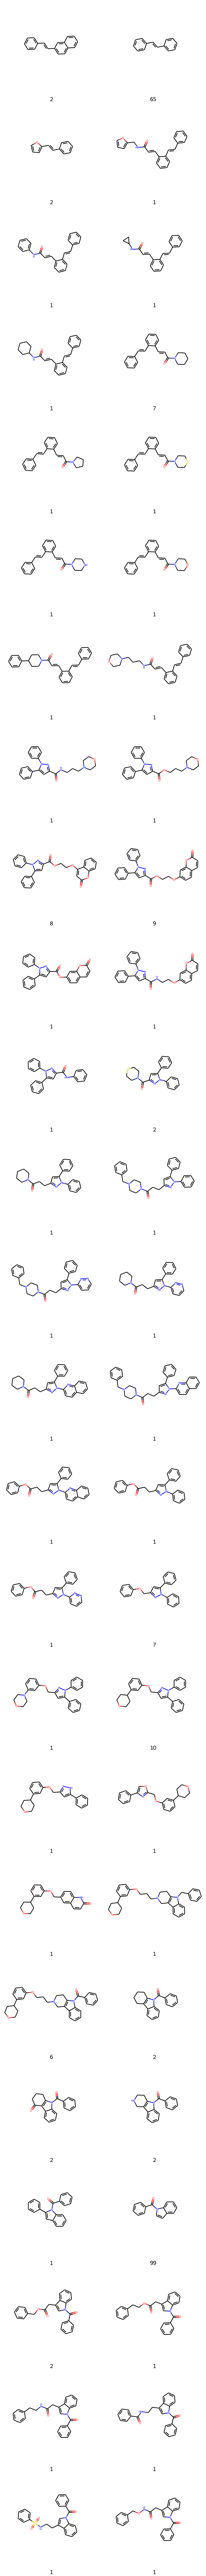

In [162]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in sorted_list[:50]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in sorted_list[:50]])

- Porovnejte složení scaffold sady ligandů a DrugBank. Jaké jsou rozdíly? Jsou scaffoldy vašeho ligandu mezi známými léky poněkud běžná, nebo je to něco exotičtějšího?

celkem mi to prislo podobne

In [266]:
from rdkit import DataStructs

def compareSimilarity(drugsBank, cox_l):
    

    less_similarity = -1
    sim_best = -1
    
    merge_l = []
    
    for i in range(len(cox_l)):
        if(i%50==0):
            print(i)
        m1 = Chem.CanonSmiles(cox_l[i][0])
        
        for j in range(len(drugsBank)): 
            
            m2 = Chem.CanonSmiles(drugsBank[j][0])
            
            if(m1==m2):
                temp = drugsBank[i]
                drugsBank[i] = drugsBank[j]
                drugsBank[j] = temp
                

        merge_l.append(cox_l[i])
#         print(cox_l[i])
        merge_l.append(drugsBank[i])
#         print(drugsBank[i])
#         print(merge_l)
    return merge_l
        

In [258]:
merge_l = compareSimilarity(scaffold_drugcount,cox_scaffold_ligandcount)
merge_l

0
50
100
150
200
250


[('C1CCC(C2CCCC2C2CCCCC2)CC1', 897),
 ('C1CCC(C2CCCC2C2CCCCC2)CC1', 20),
 ('C1CCC(CC2CCCCC2)CC1', 163),
 ('C1CCC(CC2CCCCC2)CC1', 182),
 ('C1CCC(CCC2CCCCC2)CC1', 146),
 ('C1CCC(CCC2CCCCC2)CC1', 106),
 ('C1CCC(CC2CCC3CCCCC32)CC1', 130),
 ('C1CCC(CC2CCC3CCCCC32)CC1', 25),
 ('C1CCC2CCCCC2C1', 118),
 ('C1CCC2CCCCC2C1', 170),
 ('C1CCC(C2CCCCC2C2CCCCC2)CC1', 101),
 ('C1CCC(C2CCCCC2C2CCCCC2)CC1', 2),
 ('C1CCC(CC2CCCC2)CC1', 68),
 ('C1CCC(CC2CCCC2)CC1', 74),
 ('C1CCC(C2CCCC2)CC1', 61),
 ('C1CCC(C2CCCC2)CC1', 176),
 ('C1CCC(C2CCCC2C2CCCC2)CC1', 53),
 ('C1CCC(C2CCCC2C2CCCC2)CC1', 2),
 ('C1CCCCC1', 48),
 ('C1CCCCC1', 1039),
 ('C1CCC(C2CC(C3CCCCC3)C(C3CCCCC3)C2)CC1', 47),
 ('C1CCC(C2CC(C3CCCCC3)C(C3CCCCC3)C2)CC1', 3),
 ('C1CCC(CC2CCCC2C2CCCCC2)CC1', 42),
 ('C1CCC(CC2CCCC2C2CCCCC2)CC1', 2),
 ('C1CCC(C2CC3CCCC3C2C2CCCCC2)CC1', 38),
 ('C1CCC(C2CC3CCCC3C2C2CCCCC2)CC1', 2),
 ('C1CCC(C2CC3CCCCC3C2C2CCCCC2)CC1', 37),
 ('C1CCC(C2CC3CCCCC3C2C2CCCCC2)CC1', 9),
 ('C1CCC(CC2CCCCC2C2CCCCC2)CC1', 37),
 ('C1CCC(C

In [261]:
# # merge_l = merge_l[0]
# print(type(merge_l))
# merge_l

	COX1 ligands					DrugsBank


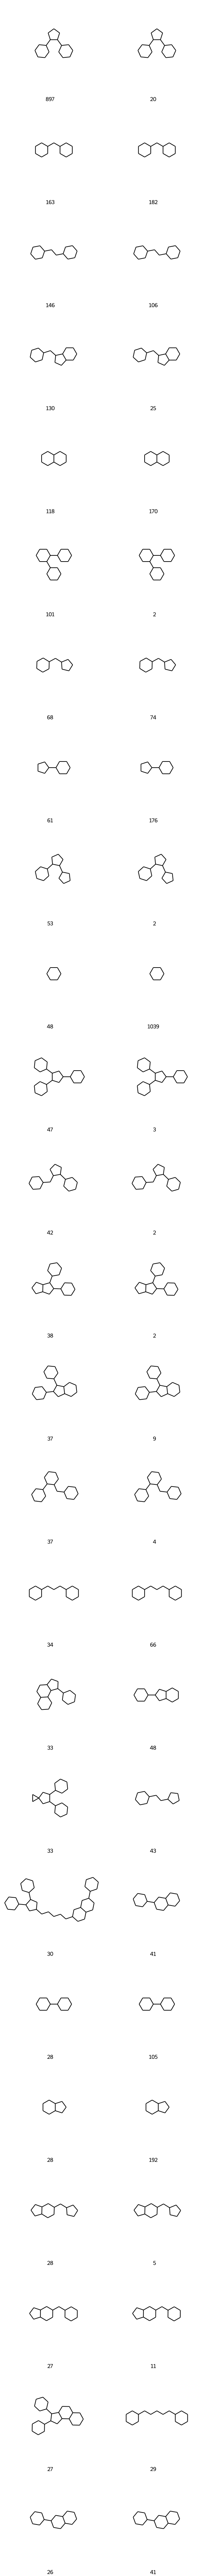

In [262]:
# jednotlive kazda mnozina
# ten prvni obrazek je pro moje ligandy COX a druhy je drugbank
print('\tCOX1 ligands\t\t\t\t\tDrugsBank')
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in merge_l[:50]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in merge_l[:50]])
# for i in range(len(drugsBank)):
# #     print(drugsBank)
# #     print(legends[i])
#     display(Draw.MolToImage(Chem.MolFromSmiles(drugsBank[i]),size=(100,100)))
#     print('\n\n')

- Proveďte výběr rozmanitosti na základě scaffoldů ze svojí sady ligandů. Reprezentujte každé scaffoldy v sadě ligandů jedinou chemickou strukturou.

## Scaffold-based diversity picking

V [předchozím cvičení](08_structural_similarity.ipynb) jsme skončili výběrem rozmanitosti, abychom vybrali malou, ale přesto reprezentativní podmnožinu naší úplné sady ligandů. Tam jsme použili jejich vzájemnou (ne) podobnost. Dalším přístupem k výběru reprezentativní podmnožiny je, jak jste již pravděpodobně uhodli, scaffold. Dělá se to poměrně často pro účely [průzkumu chemického prostoru](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998053/), ale stejně snadno se dá použít k prezentaci chemiků s některými skutečnými struktury, které podporují abstraktnější analýzu scaffoldu.

Tento typ výběru rozmanitosti je v pojetí zcela přímočarý, znamená to pouze reprezentaci každého scaffoldu jedinou strukturou (často tou nejsilnější) nebo nějakým způsobem [stratifikovaný odběr vzorků](https://en.wikipedia.org/wiki/ Stratified_sampling) z různých scaffoldů.

Zkusme nejjednodušší přístup a představme každý scaffold v našem ligandu nastavené jeho nejaktivnějším (podle hodnoty pChEMBL) ligandu:

- bereme scaffold a k nemu vezmeme latku/reprezentanta, ktera ma nejvetsi aktivitu dle pChEMBL

In [263]:
scaffold_representatives = {}
for scaffold, ligands in cox_scaffolds2ligands.items():
    scaffold_representatives[scaffold] = sorted(ligands,
                                                key=lambda x: cox_ligands[x].GetProp('pChEMBL'),
                                                reverse=True)[0]
len(scaffold_representatives), scaffold_representatives

(281,
 {'C1CCC(CCC2CCCCC2)CC1': 2888,
  'C1CCC(C2CCCC2C2CCCCC2)CC1': 3,
  'C1CCC(C2CC3CCCCC3C2C2CCCCC2)CC1': 2457,
  'C1CCC2CCCCC2C1': 2317,
  'C1CCC2C(C1)CC1C2CCCC12CCC1CCCCC12': 8,
  'C1CCCCC1': 2903,
  'C1CCC(CC2CCCCC2)CC1': 794,
  'C1CCC(C2CCCCC2C2CCCCC2)CC1': 1853,
  'C1CCC(C2CCCC(CC3CCCC3)C2)CC1': 2726,
  'C1CCC(C2CCCCC2)CC1': 607,
  'C1CCC(CCCCC2CC(CC3CCCCC3)C3CCCCC23)CC1': 1336,
  'C1CCC(C2CCCC(C3CCCCC3)C2)CC1': 21,
  'C1CCC(C2CCCC2)CC1': 3173,
  'C1CCC(CC2CCC3CCCCC32)CC1': 1061,
  'C1CCC(C2CC3CCCC3C2C2CCCCC2)CC1': 86,
  'C1CCC2CCCC2C1': 34,
  'C1CCC(C2CCC3CCCCC3C2)CC1': 1111,
  'C1CCC(CC2CCC3CCCC3C2)CC1': 1669,
  'C1CCC(C2CC(C3CCCCC3)C(C3CCCCC3)C2)CC1': 945,
  'C1CCC(C2CCC3CCC4CCCCC4C32)CC1': 2946,
  'C1CCC(CC2CCC(C3CCCCC3)C(C3CCCCC3)C2)CC1': 460,
  'C1CCC(CC2CCCCC2C2CCCCC2)CC1': 1453,
  'C1CCC(CC2CCCC2)CC1': 2783,
  'C1CCC(C2CCC3CCCC(C4CC(C5CCCCC5)CC5CCCCC54)C3C2)CC1': 964,
  'C1CCC(CCC2CCCC3CCCCC32)CC1': 2262,
  'C1CCC(C2CCCC2C2CCCC3CCCCC32)CC1': 1455,
  'C1CCC(C2CCCCC2CC2CC

In [264]:
# prep for our amazing visualization of scaffolds and representative structures side by side :)
scaffold_representatives4visualization = []
for scaffold, ligandcount in cox_scaffold_ligandcount:
    mol = Chem.MolFromSmiles(scaffold)
    mol.SetProp('legend', str(ligandcount) + " ligands")
    scaffold_representatives4visualization.append(mol)
    representative_mol = cox_ligands[scaffold_representatives[scaffold]]
    representative_mol.SetProp('legend', "#{} | pChEMBL {}".format(str(scaffold_representatives[scaffold]),
                                                            representative_mol.GetProp('pChEMBL')))
    scaffold_representatives4visualization.append(representative_mol)
len(scaffold_representatives4visualization), scaffold_representatives4visualization[:20]

(562,
  <rdkit.Chem.rdchem.Mol at 0x7f8a86fcccb0>])

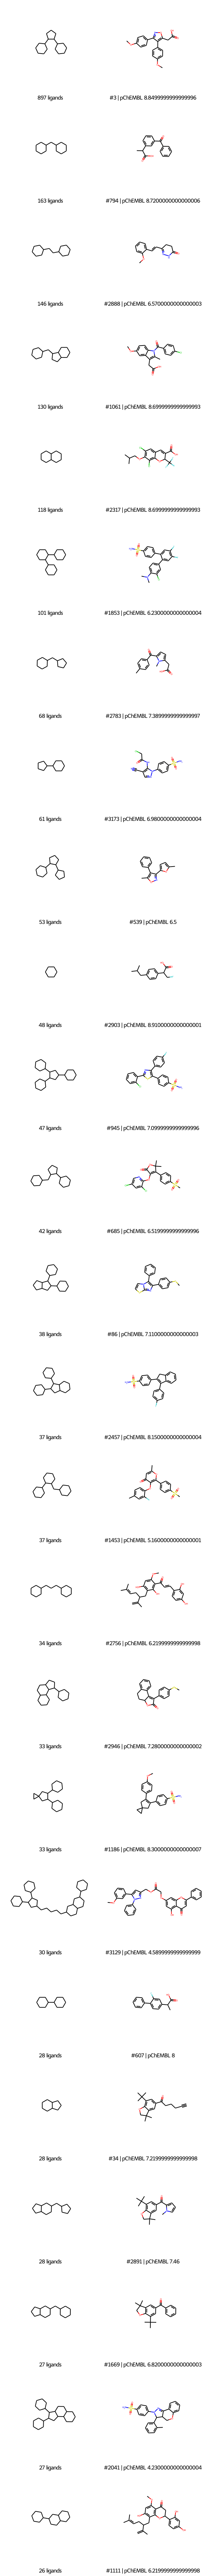

In [265]:
Draw.MolsToGridImage(scaffold_representatives4visualization[:50],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[mol.GetProp('legend')
                              for mol in scaffold_representatives4visualization[:50]])